In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class
from GRF_perturbations.Modules.Image_processing import scipy_fit_image
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import Inference_class,infer_LogNorm_params,Inference_pipeline,compute_SNR_grid,plot_likelihood,get_conf_intervals,Spectra_Loss,compute_Loss_grid

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Observation conditions

In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)
Inference=Inference_class(Observation_conditions)

del Observation_conditions_class
del Inference_class

Precomputing Fourier phases
Precompiling source-lens loss,gradient,hessian
Precomputing loss
Precomputing loss gradient
Precomputing loss hessian
Inference class is ready


In [3]:
noise_var=Observation_conditions.noise_var
parameters=Observation_conditions.parameters
Estimated_Noise_spectral_density=(noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()

# Unperturbed image

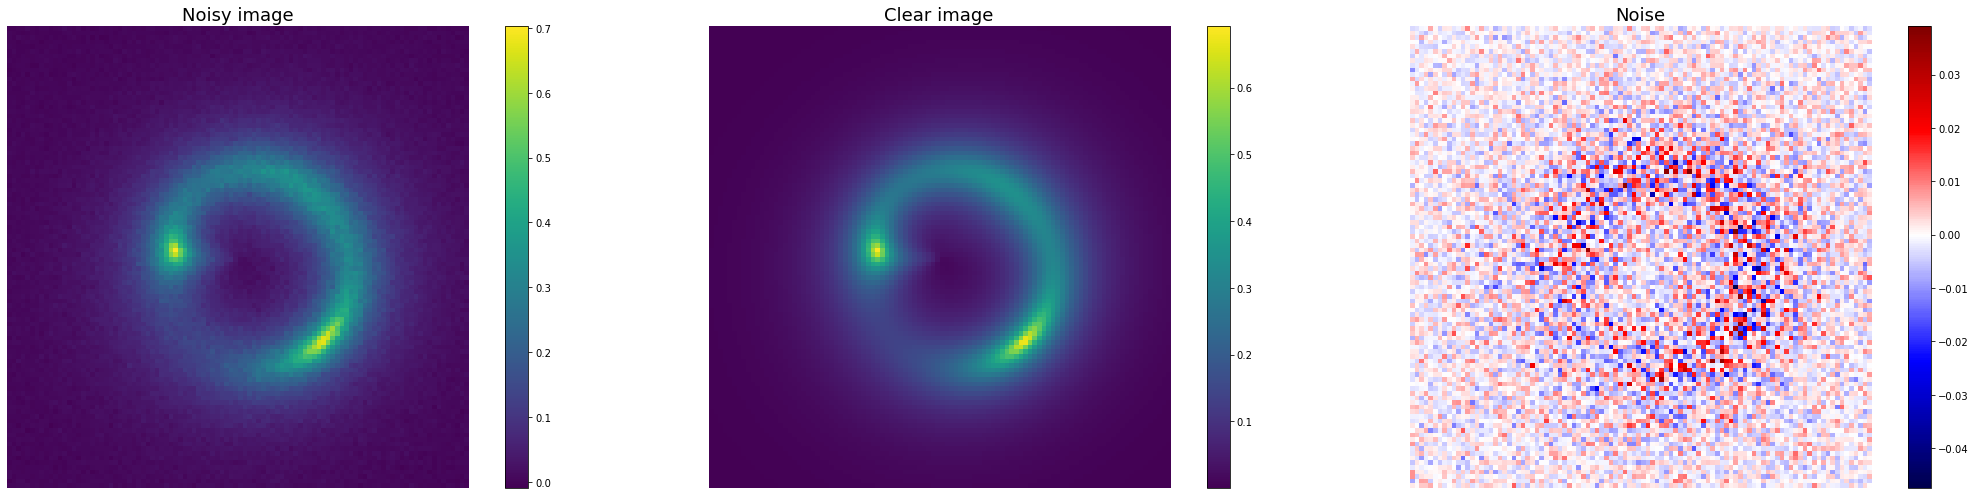

In [4]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)
Image_unperturbed_noisy=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=42)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(Image_unperturbed_noisy)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(Image_unperturbed_noisy-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

# GRF Spectra grid

In [5]:
grid_size=128
logA_array=np.linspace(-9.7,-6.87,grid_size)
Beta_array=np.linspace(0,4.7,grid_size)
GRF_seeds_number=100

Spectra_grid=np.load('../Processing_scripts/results/Spectra_grid_node_0.npz')['arr_0']
for i in range(1,4):
    Spectra_grid=np.append(Spectra_grid,np.load('../Processing_scripts/results/Spectra_grid_node_{}.npz'.format(i))['arr_0'],axis=0)

In [6]:
SNR_grid=compute_SNR_grid(Spectra_grid,Estimated_Noise_spectral_density)

/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Inference.py:204: RuntimeWarning: invalid value encountered in log10
  SNR=10*np.log10(np.mean(Spectra_grid-Noise_spectral_density,axis=-1)/Noise_spectral_density)


In [7]:

y_labels=np.round(logA_array,2)
x_labels=np.round(Beta_array,2)

num_ticks = 8
# the index of the position of yticks
ticks = np.linspace(0, len(logA_array) - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)

def set_labels_plt(fontsize):
    plt.gca().set_yticklabels(yticklabels,fontsize=fontsize)
    plt.gca().set_xticklabels(xticklabels,fontsize=fontsize)
    
def plot_line(ax_row,data_image,residuals_image,GRF_potential,likelihood,Confidence_grid,SNR,\
              true_logA_index,true_Beta_index,pred_logA_index,pred_Beta_index,ylabel,\
              logA_ind_lim=(0,160),Beta_ind_lim=(0,214),legend_flag=True,titles_flag=True):
    #Data
    im=ax_row[0].imshow(data_image,origin='lower')
    cbar=fig.colorbar(im,ax=ax_row[0],ticks=[0,0.2,0.4,0.6,math.floor(data_image.max()*100)/100],fraction=0.045)
    cbar.ax.set_ylabel('Flux',rotation=90,fontsize=12,labelpad=0)
    
    #Potential
    im=ax_row[1].imshow(GRF_potential,cmap='Spectral',norm=mpl.colors.TwoSlopeNorm(0),origin='lower')
    cbar=fig.colorbar(im,ax=ax_row[1],ticks=[math.ceil(GRF_potential.min()*1e+2)/1e+2,0,math.floor(GRF_potential.max()*1e+2)/1e+2],fraction=0.045)
    cbar.ax.set_ylabel(r'$\delta \psi$',rotation=90,fontsize=12,labelpad=0)
    
    #masked_resid=resids_images[i]*mask
    #norm_masked_resid=(resids_images[i]/np.sqrt(noise_vars[i]))*mask
    
    #Residuals
    normalised_masked_residuals=(residuals_image*Observation_conditions.annulus_mask)/np.sqrt(noise_var)
    colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]
    
    im=ax[i,2].imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),origin='lower')
    cbar=fig.colorbar(im,ax=ax_row[2],ticks=colorborders,fraction=0.045)
    cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
    cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    #fig.colorbar(im,ax=ax[i,2],ticks=[math.ceil(resids_images[i].min()*1e+3)/1e+3,0,math.floor(resids_images[i].max()*1e+3)/1e+3],fraction=0.045)
    
    
    Crop_Beta_arr=Beta_array[Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_logA_arr=logA_array[logA_ind_lim[0]:logA_ind_lim[1]]
    Crop_likelihood=likelihood[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_confidence=Confidence_grid[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_SNR=SNR[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    
    
    Like_xticks=np.arange(10)
    Like_xticks=Like_xticks[np.where( (Like_xticks>=Crop_Beta_arr[0]) & (Like_xticks<=Crop_Beta_arr[-1]) )[0]]
    Like_yticks=np.arange(0,8)*0.5-9.5
    Like_yticks=Like_yticks[np.where( (Like_yticks>=Crop_logA_arr[0]) & (Like_yticks<=Crop_logA_arr[-1]) )[0]]
    
    
    plot_likelihood(ax_row[3],Crop_Beta_arr,Crop_logA_arr,Crop_confidence,Crop_SNR,true_logA_index-logA_ind_lim[0],true_Beta_index-Beta_ind_lim[0],\
                    pred_logA_index-logA_ind_lim[0],pred_Beta_index-Beta_ind_lim[0],Like_xticks,Like_yticks,legend_flag)
    
    ra_at_xy_0,dec_at_xy_0=Observation_conditions.pixel_grid.radec_at_xy_0
    
    for j in range(3):
        ax_row[j].set_xticks([0,50,100-1])
        ax_row[j].set_xticklabels([ra_at_xy_0,0,-ra_at_xy_0])
        ax_row[j].set_xlabel('arcsec')
        
        if j!=0:
            ax_row[j].set_yticks([0,50,100-1])
            ax_row[j].set_yticklabels([dec_at_xy_0,0,-dec_at_xy_0])
            ax_row[j].set_ylabel('arcsec',labelpad=-15)
        else:
            ax_row[j].set_yticks([])
            ax_row[j].set_ylabel('arcsec',labelpad=20)
        
    if titles_flag:
        titles=['Imaging data','Potential perturbations','Normalised residuals','Perturbations confidence']
        for j in range(4):
            ax_row[j].set_title(titles[j],fontsize=FS)
        
        
    box=ax_row[3].get_position()
    box.x0 = box.x0 + 0.02 
    ax_row[3].set_position(box)
    
    sup_ax=ax_row[0].twiny().twinx()
    sup_ax.yaxis.set_label_position('left')
    sup_ax.set_xticks([])
    
    sup_ax.yaxis.tick_left()
    #sup_ax.set_yticks([])
    sup_ax.set_yticks([0,50,100-1])
    sup_ax.set_yticklabels([dec_at_xy_0,0,-dec_at_xy_0])
    #sup_ax.set_ylabel('arcsec',labelpad=-15)
    
    
    sup_ax.set_ylabel(ylabel,fontsize=FS,rotation=0)
    #sup_ax.set_ylabel(r"${\rm log}(A)$",fontsize=FS,rotation=0)
    sup_ax.yaxis.set_label_coords(-0.3,0.38)

# GRF meta prediction

In [11]:
!ls ../Processing_scripts/results/prediction/


Predictions_grid_node_0.npz       Predictions_grid_node_3.npz
Predictions_grid_node_1.npz       Predictions_grid_test__node_0.npz
Predictions_grid_node_2.npz       shape.npy


In [12]:
Prediction_grid=np.load('../Processing_scripts/results/prediction/Predictions_grid_node_0.npz')['arr_0']

for i in range(1,4):
    Prediction_grid=np.append(Prediction_grid,np.load('../Processing_scripts/results/prediction/Predictions_grid_node_{}.npz'.format(i))['arr_0'],axis=0)

In [13]:
Prediction_array.shape

(128, 128, 100, 7, 2)

In [15]:
predicted_indices=Prediction_grid[:,:,:,0]
logA_confidence_regions=Prediction_grid[:,:,:,1:4]
Beta_confidence_regions=Prediction_grid[:,:,:,4:]

In [18]:
true_indices=np.array([np.arange(0,len(logA_array)),np.arange(0,len(Beta_array))])

# Median likelihood and 1d contours

## Bias and uncertainty

In [19]:
predicted_bias=np.zeros((len(logA_array),len(Beta_array),100,2))

uncertainty_width=np.zeros((len(logA_array),len(Beta_array),100,2,3))


average_prediction=predicted_indices.mean(axis=-2)
for i in range(len(logA_array)):
    for j in range(len(Beta_array)):
        
        logA_uncertainty_width=logA_confidence_regions[i,j,:,:,1]-logA_confidence_regions[i,j,:,:,0]
        Beta_uncertainty_width=Beta_confidence_regions[i,j,:,:,1]-Beta_confidence_regions[i,j,:,:,0]
        
        uncertainty_width[i,j,:,0,:]=logA_uncertainty_width
        uncertainty_width[i,j,:,1,:]=Beta_uncertainty_width
        
        predicted_bias[i,j,:,0]=(predicted_indices[i,j,:,0]-true_indices[0][i])
        predicted_bias[i,j,:,1]=(predicted_indices[i,j,:,1]-true_indices[1][j])

## Bias

In [31]:
uncertainty_width.shape

(128, 128, 100, 2, 3)

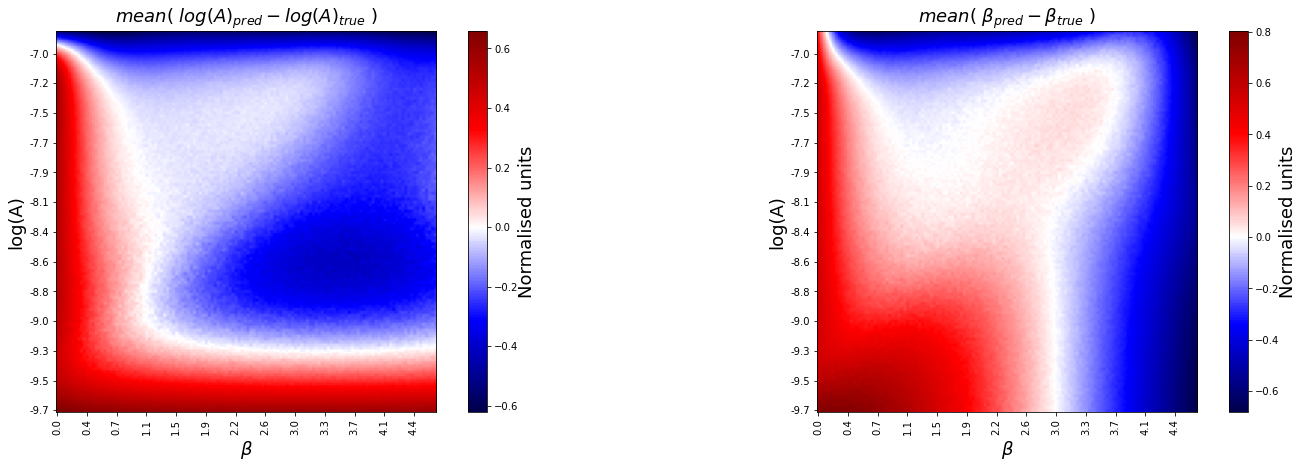

In [34]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

mean_bias=(predicted_bias/uncertainty_width[:,:,:,:,0]).mean(axis=-2)

img_arr+=[ax[0].imshow(mean_bias[:,:,0],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
img_arr+=[ax[1].imshow(mean_bias[:,:,1],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=[r'$mean( \ log(A)_{pred}-log(A)_{true} \ )$',r'$mean( \ \beta_{pred}-\beta_{true} \ )$']
units=['Normalised units','Normalised units']

for i in range(2):
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(0,len(logA_array),10))
    ax[i].set_yticklabels(logA_array[::10].round(1))
    
    ax[i].set_xticks(np.arange(0,len(Beta_array),10))
    ax[i].set_xticklabels(Beta_array[::10].round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

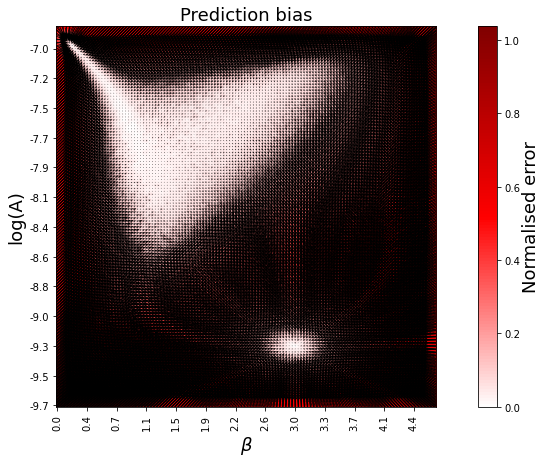

In [41]:
plt.figure(figsize=(15,7))
X,Y=np.meshgrid(Beta_array,logA_array)
I=mean_bias[:,:,1]
J=mean_bias[:,:,0]

img=plt.imshow(np.sqrt(I**2+J**2),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1)
plt.quiver(I, J,scale=10,width=0.002,headwidth=7,headlength=7.5,pivot='middle')


plt.gca().patch.set(hatch="+", edgecolor='black',alpha=0.05)

plt.gca().invert_yaxis()
plt.yticks(np.arange(0,len(logA_array),10),logA_array[::10].round(1))
plt.xticks(np.arange(0,len(Beta_array),10),Beta_array[::10].round(1),rotation=90)

plt.title('Prediction bias',fontsize=FS)
plt.ylabel('log(A)',fontsize=FS)
plt.xlabel(r'$\beta$',fontsize=FS)
cbar=plt.colorbar(img)
cbar.ax.set_ylabel('Normalised error',rotation=90,fontsize=FS,labelpad=2)
plt.show()

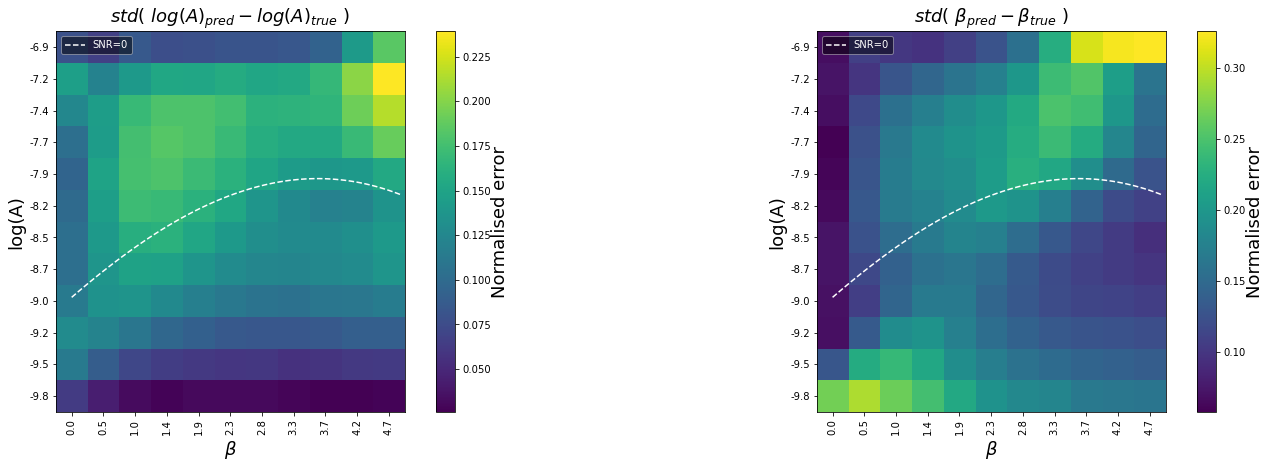

In [197]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

std_bias=(predicted_bias/uncertainty_width[:,:,:,:,0]).std(axis=-2)

img_arr+=[ax[0].imshow(std_bias[:,:,0])]
img_arr+=[ax[1].imshow(std_bias[:,:,1])]

#img_arr+=[ax[0].imshow(Perturbation_matrix*std_bias[:,:,0])]
#img_arr+=[ax[1].imshow(Perturbation_matrix*std_bias[:,:,1])]

titles=[r'$std( \ log(A)_{pred}-log(A)_{true} \ )$',r'$std( \ \beta_{pred}-\beta_{true} \ )$']
units=['Normalised error','Normalised error']

for i in range(2):
    
    
    ax[i].patch.set(hatch="+", edgecolor='black',alpha=0.05)
    
    #ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='w',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='k')
    l.get_texts()[0].set_color('w')
    #l.get_texts()[1].set_color('w')
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

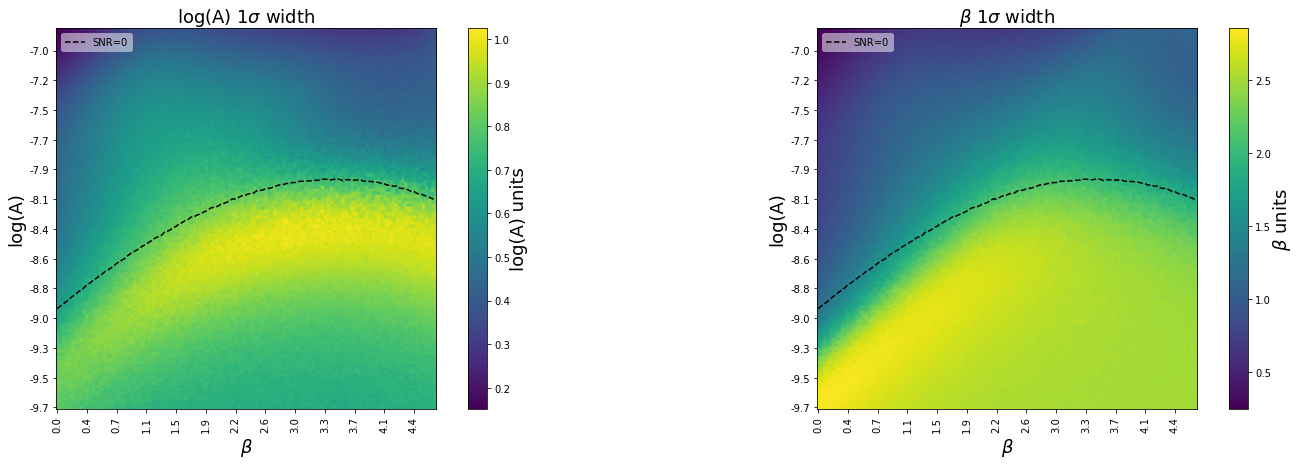

In [48]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

sigma=1
mean_uncert=uncertainty_width.mean(axis=2)



img_arr+=[ax[0].imshow(mean_uncert[:,:,0,sigma-1]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[1].imshow(mean_uncert[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0]))]


titles=['log(A) '+str(sigma)+r'$\sigma$'+' width',r'$\beta$ '+str(sigma)+r'$\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    
    #ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='w')
    l.get_texts()[0].set_color('k')
    #l.get_texts()[1].set_color('w')
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(0,len(logA_array),10))
    ax[i].set_yticklabels(logA_array[::10].round(1))
    
    ax[i].set_xticks(np.arange(0,len(Beta_array),10))
    ax[i].set_xticklabels(Beta_array[::10].round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

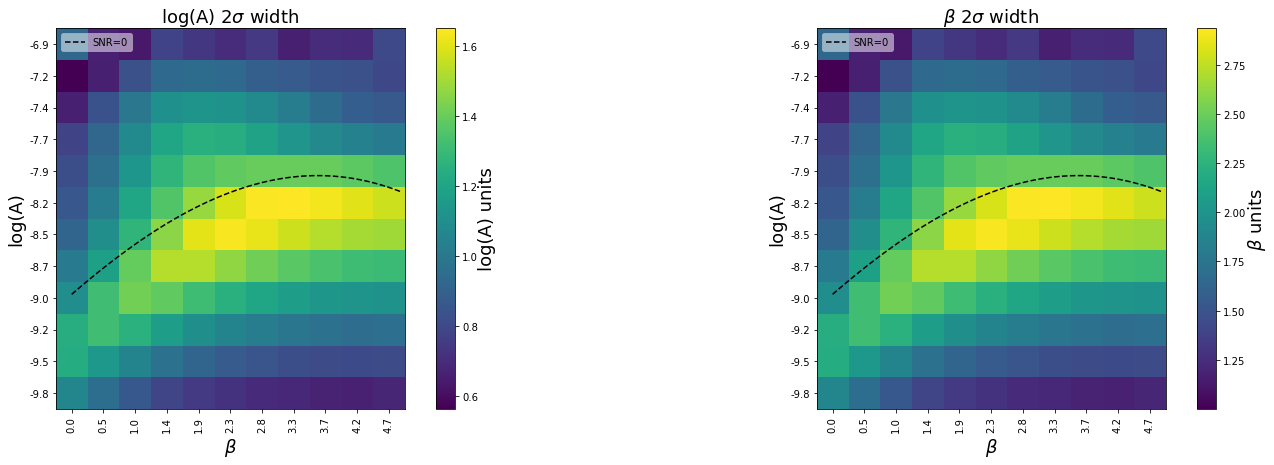

In [210]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

sigma=2
mean_uncert=uncertainty_width.mean(axis=2)



img_arr+=[ax[0].imshow(mean_uncert[:,:,0,sigma-1]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[1].imshow(mean_uncert[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0]))]


titles=['log(A) '+str(sigma)+r'$\sigma$'+' width',r'$\beta$ '+str(sigma)+r'$\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    
    #ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='k',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='w')
    l.get_texts()[0].set_color('k')
    #l.get_texts()[1].set_color('w')
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

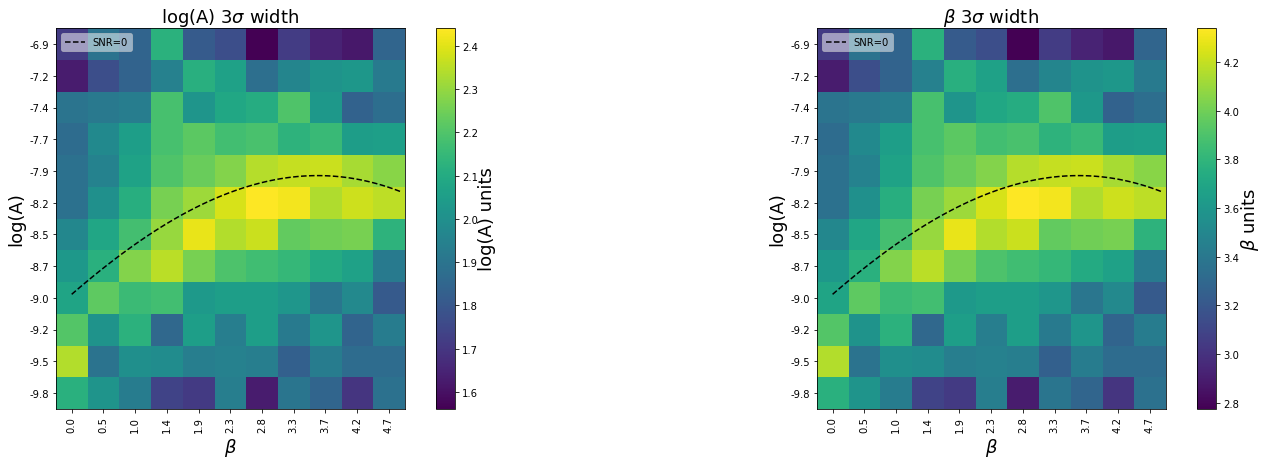

In [211]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

sigma=3
mean_uncert=uncertainty_width.mean(axis=2)



img_arr+=[ax[0].imshow(mean_uncert[:,:,0,sigma-1]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[1].imshow(mean_uncert[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0]))]


titles=['log(A) '+str(sigma)+r'$\sigma$'+' width',r'$\beta$ '+str(sigma)+r'$\sigma$'+' width']
units=['log(A) units',r'$\beta$'+' units']

for i in range(2):
    
    
    #ax[i].plot(Beta_threshold_indices,logA_threshold_indices,color='w',label='Perturbation constraint')
    
    
    imgSNR=ax[i].contour(np.arange(0,len(Beta_array))/11,np.arange(0,len(logA_array))/11,SNR_grid,[0],colors='k',linestyles='--')
    imgSNR.collections[0].set_label('SNR=0')
    l=ax[i].legend(loc='upper left',framealpha=0.5,facecolor='w')
    l.get_texts()[0].set_color('k')
    #l.get_texts()[1].set_color('w')
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(len(Coarse_logA_array)))
    ax[i].set_yticklabels(Coarse_logA_array.round(1))
    
    ax[i].set_xticks(np.arange(len(Coarse_Beta_array)))
    ax[i].set_xticklabels(Coarse_Beta_array.round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)